In [56]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import numpy as np
import seaborn as sns
from scipy.stats import norm
from sklearn.metrics import precision_score, recall_score, accuracy_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
import warnings
warnings.filterwarnings('ignore')
from datetime import datetime
from sklearn.model_selection import RandomizedSearchCV, cross_validate, cross_val_score
from sklearn.metrics import roc_auc_score, make_scorer
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier
from sklearn.metrics import precision_score, recall_score, balanced_accuracy_score
import matplotlib.pyplot as plt
from sklearn.model_selection import RepeatedStratifiedKFold
from mlxtend.classifier import StackingCVClassifier, EnsembleVoteClassifier
from mlxtend.feature_selection import ColumnSelector
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer, KNNImputer

In [194]:
params = {'n_estimators': [300, 400, 500, 600, 700],
              'learning_rate': [0.01, 0.02, 0.03, 0.05, 0.07],
              'gamma': [0.5, 1, 1.5, 2, 5],
              'max_depth': [3, 4, 5, 6],
              'subsample': [0.6, 0.8, 1.0],
              'colsample_bytree': [0.6, 0.8, 1.0],
              'min_child_weight': [1, 2, 3, 4, 5]}

seed = 42
st_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

def calc_scores(clf, X_test, y_test):
    y_pred = clf.predict(X_test)
    recall_0, recall_1 = recall_score(y_test, y_pred, pos_label=0), recall_score(y_test, y_pred, pos_label=1)
    precision_0, precision_1 =  precision_score(y_test, y_pred, pos_label=0), precision_score(y_test, y_pred, pos_label=1)
    acc = balanced_accuracy_score(y_test, y_pred)
    auc_score = roc_auc_score(y_test, clf.predict_proba(X_test)[:,1])
    arr = np.array([[acc, precision_0, recall_0, precision_1, recall_1,auc_score]])
    return pd.DataFrame(data=arr, columns=["balanced_accuracy", "recall_0", "precision_0", "recall_1", "precision_1", "auc"])

def recall_0(y_true, y_pred):
    return recall_score(y_true, y_pred, pos_label=0)

def precision_0(y_true, y_pred):
    return precision_score(y_true, y_pred, pos_label=0)

scoring = {"balanced_accuracy": make_scorer(balanced_accuracy_score),
           "recall_0": make_scorer(recall_0), "precision_0": make_scorer(precision_0),
           "recall_1": make_scorer(recall_score), "precision_1": make_scorer(precision_score), "auc": "roc_auc" }

#cross_validation

def print_score_comparison(raw_score, emb_score, target_feature="posOutcome",
                           header_1="Raw Score", header_2="Embedding Score"):
    print("\t\t{0}\n\t\t\t{1}\t\t{2}".format(target_feature, header_1, header_2))
    print("\t\t-----------------------------------------------")
    print("balanced_accuracy:\t{0:.3%}\t\t\t{1:.3%}\n".format(raw_score["balanced_accuracy"].mean(), emb_score["balanced_accuracy"].mean()))
    print("precision_0:\t\t{0:.3%}\t\t\t{1:.3%}\n".format(raw_score["precision_0"].mean(), emb_score["precision_0"].mean()))
    print("recall_0:\t\t{0:.3%}\t\t\t{1:.3%}\n".format(raw_score["recall_0"].mean(), emb_score["recall_0"].mean()))
    print("precision_1:\t\t{0:.3%}\t\t\t{1:.3%}\n".format(raw_score["precision_1"].mean(), emb_score["precision_1"].mean()))
    print("recall_1:\t\t{0:.3%}\t\t\t{1:.3%}\n".format(raw_score["recall_1"].mean(), emb_score["recall_1"].mean()))
    print("auc:\t\t\t{0:.3%}\t\t\t{1:.3%}\n".format(raw_score["auc"].mean(), emb_score["auc"].mean()))

def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time

    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))

def param_tuning(X, y, n_folds=5, param_comb=25, scoring='roc_auc', jobs=12):
    xgb = XGBClassifier(learning_rate=0.02, n_estimators=600, objective='binary:logistic',
                    silent=True, nthread=1)
    skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)
    rand_search = RandomizedSearchCV(xgb, param_distributions=params, n_iter=param_comb, scoring=scoring, n_jobs=jobs,
                                   cv=skf.split(X, y), verbose=3, random_state=42)

    start_time = timer(None) # timing starts from this point for "start_time" variable
    rand_search.fit(X, y)
    timer(start_time)
    print("Best Score: {:.3%}".format(rand_search.best_score_))
    print(rand_search.best_params_)
    return rand_search

score_cols = ["test_balanced_accuracy","test_precision_0", "test_recall_0",
               "test_precision_1","test_recall_1", "test_auc"]

def get_scores(cv_results, score_keys=None, df_cols=None):
    if score_keys is None:
        score_keys = score_cols
    if df_cols is None:
        score_keys = score_cols
    scores = np.empty([1, len(score_keys)])
    for i, s in enumerate(score_keys):
        scores[0][i] = np.mean(cv_results[s])
    scores_df = pd.DataFrame(data=scores, columns=df_cols)
    return scores_df

def evaluate_embedding(path, outcome_df, target="posOutcome", merge_col="patient_ID", n_jobs=-1):
    emb_df = pd.read_csv(path, sep="\t")
    emb_outcome_df = pd.merge(outcome_df, emb_df, on=merge_col)
    X_emb, y_emb = emb_outcome_df[emb_outcome_df.columns.difference([merge_col, target])], emb_outcome_df[target]
    X_train_emb, X_test_emb, y_train_emb, y_test_emb = train_test_split(X_emb, y_emb, test_size=0.3, random_state=seed)
    rand_search_emb = param_tuning(X_train_emb, y_train_emb, jobs=n_jobs)
    params = rand_search_emb.best_params_
    clf_emb = rand_search_emb.best_estimator_
    cv_res = cross_validate(clf_emb, X_train_emb, y_train_emb, scoring=scoring, n_jobs=n_jobs, verbose=1, return_train_score=True,
                            cv=st_cv)
    cv_res_df = get_scores(cv_res)
    clf_emb.fit(X_train_emb, y_train_emb)
    test_scores_df = calc_scores(clf_emb, X_test_emb, y_test_emb)

    return params, cv_res_df, test_scores_df

def load_features(path):
    feats = []
    with open(path, "r") as fp:
        for line in fp.readlines():
            feats.append(line.strip())

    return feats
def evaluate_ge(x_train, y_train, x_test, y_test, outcome_cols=None, feats=None, jobs=-1,
                scoring=scoring, rand_scoring="roc_auc", target="posOutcome"):
    if feats is not None:
        if outcome_cols is not None:
            cols = outcome_cols + feats
        else:
            cols = feats
        x_train = x_train[cols]
        x_test = x_test[cols]
    rand_search = param_tuning(x_train, y_train, scoring=rand_scoring, jobs=jobs)
    params = rand_search.best_params_
    clf = XGBClassifier(**params)
    cv_res = cross_validate(clf, x_train, y_train,scoring=scoring, cv=st_cv, n_jobs=jobs)

    cv_res_df = get_scores(cv_res, score_cols, df_cols=["balanced_accuracy", "recall_0", "precision_0", "recall_1", "precision_1", "auc"])
    clf.fit(x_train, y_train)
    test_scores_df = calc_scores(clf, x_test, y_test)

    return params, clf, cv_res_df, test_scores_df

def discretize_dataset(X, features, bins_labels = None):
    if bins_labels is None:
	    bins_labels = [-1, 0, 1]
    X_disc = X[features]
    bin_dict = {}

    for ft in features:
        r1 = X_disc[ft].mean() - X_disc[ft].std() / 2
        r2 = X_disc[ft].mean() + X_disc[ft].std() / 2
        bin_dict[ft]= [-np.inf, r1, r2, np.inf]
    le = LabelEncoder()

    le.fit(bins_labels)

    for ft in bin_dict:
        X_disc[ft] = le.transform(pd.cut(X_disc[ft], bins=bin_dict[ft], labels=bins_labels))

    ohe = OneHotEncoder(handle_unknown="ignore")
    transformed = ohe.fit_transform(X_disc).toarray()
    X_disc = pd.DataFrame(transformed, columns=ohe.get_feature_names(features))
    return X_disc

In [169]:
#Load the datasets

ge_df = pd.read_csv("datasets/merged-combat15.csv")
state_df = pd.read_csv("datasets/state_and_outcome.csv")

In [170]:
#Feature engineering

state_df = state_df.drop(["series_id", "channel_count", "RFS", "DFS",
                          "pCR", "posOutcome2"], axis=1)

In [171]:
gpl_vals = state_df["gpl"].unique()
print(gpl_vals)
pam_subtypes = state_df["pam_coincide"].unique()
print(pam_subtypes)
p5_types = state_df["p5"].unique()
print(p5_types)
tumor_types = state_df["tumor"].unique()
print(tumor_types)

['GPL570' 'GPL96' 'GPL1708,GPL4133' 'GPL5049' 'GPL1223' 'GPL5325']
['LumB' 'Her2' 'Basal' nan 'LumA' 'Normal']
['k5' 'k3' 'k1' 'k2' 'k4' nan]
['T3' 'T2' 'T4' 'T1' nan 'T0']


In [176]:
state_df = state_df.dropna(axis=0, subset=["pam_coincide", "p5"])
state_df = state_df.reset_index(drop=True)

In [177]:
state_df["tumor"] = state_df["tumor"].astype("category").cat.codes
state_df["pam_coincide"] = pam_code_df = state_df["pam_coincide"].astype("category").cat.codes
state_df["p5"] = p5_code_df = state_df["p5"].astype("category").cat.codes
state_df["gpl"] = gpl_code = state_df["gpl"].astype("category").cat.codes
state_df

,patient_ID,gpl,ER,HER2,PR,node,tumor,pam_coincide,p5,posOutcome
0,809184,4,1.0,0.0,0.0,1.0,4,3,4,0
1,809185,4,0.0,0.0,0.0,1.0,4,3,4,1
2,809186,4,0.0,0.0,0.0,1.0,4,1,2,0
3,809187,4,1.0,1.0,1.0,1.0,4,3,4,0
4,809188,4,1.0,0.0,1.0,1.0,3,0,0,0
...,...,...,...,...,...,...,...,...,...,...
2220,491199,4,0.0,0.0,0.0,0.0,3,0,1,1
2221,491270,4,1.0,1.0,1.0,0.0,3,3,4,1
2222,491200,4,0.0,1.0,0.0,1.0,3,1,1,1
2223,491201,4,0.0,0.0,0.0,0.0,3,0,3,1


In [178]:
cat_fts = ["gpl", "pam_coincide", "p5"]
X_cats = state_df[cat_fts]
print(X_cats.shape)
ohe = OneHotEncoder()
X_ohe = ohe.fit_transform(X_cats).toarray()
print(X_ohe.shape)
fts_names = ohe.get_feature_names(cat_fts)
ohe_df = pd.DataFrame(X_ohe, columns=fts_names)
state_df_v2 = pd.concat([state_df.drop(cat_fts, axis=1), ohe_df], axis=1)
state_df_v2

(2225, 3)
(2225, 16)


,patient_ID,ER,HER2,PR,node,tumor,posOutcome,gpl_0,gpl_1,gpl_2,...,pam_coincide_0,pam_coincide_1,pam_coincide_2,pam_coincide_3,pam_coincide_4,p5_0,p5_1,p5_2,p5_3,p5_4
0,809184,1.0,0.0,0.0,1.0,4,0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1,809185,0.0,0.0,0.0,1.0,4,1,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2,809186,0.0,0.0,0.0,1.0,4,0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,809187,1.0,1.0,1.0,1.0,4,0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
4,809188,1.0,0.0,1.0,1.0,3,0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2220,491199,0.0,0.0,0.0,0.0,3,1,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2221,491270,1.0,1.0,1.0,0.0,3,1,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2222,491200,0.0,1.0,0.0,1.0,3,1,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2223,491201,0.0,0.0,0.0,0.0,3,1,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [112]:
from sklearn.metrics import mean_squared_error as rmse
def optimize_k(df, target, exclude=None):
    if exclude is None:
        exclude = ["patient_ID"]
    df = df.drop(exclude, axis=1)
    data = df.to_numpy()
    errors = []
    for k in range(1, 20, 2):
        imputer = KNNImputer(n_neighbors=k)
        imputed = imputer.fit_transform(data)
        df_imputed = pd.DataFrame(imputed, columns=df.columns)

        X = df_imputed.drop(target, axis=1)
        y = df_imputed[target]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        model = RandomForestClassifier()
        model.fit(X_train, y_train)
        preds = model.predict(X_test)
        error = rmse(y_test, preds)
        errors.append({'K': k, 'RMSE': error})

    return errors

In [113]:
knn_errors = optimize_k(state_df_v2, "posOutcome")
knn_errors

[{'K': 1, 'RMSE': 0.2700892857142857},
 {'K': 3, 'RMSE': 0.24330357142857142},
 {'K': 5, 'RMSE': 0.22544642857142858},
 {'K': 7, 'RMSE': 0.22321428571428573},
 {'K': 9, 'RMSE': 0.21205357142857142},
 {'K': 11, 'RMSE': 0.22991071428571427},
 {'K': 13, 'RMSE': 0.22098214285714285},
 {'K': 15, 'RMSE': 0.203125},
 {'K': 17, 'RMSE': 0.19419642857142858},
 {'K': 19, 'RMSE': 0.19419642857142858}]

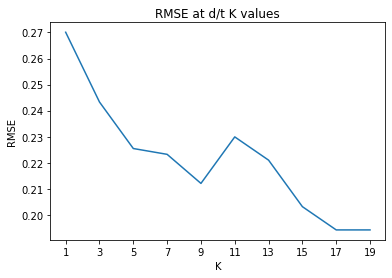

In [114]:
x = []
y = []

for i in knn_errors:
    x.append(i["K"])
    y.append(i["RMSE"])

x = np.array(x)
y = np.array(y)
fig, ax = plt.subplots()
ax.plot(x, y)
ax.set_xlabel("K")
ax.set_ylabel("RMSE")
ax.set_title("RMSE at d/t K values")
plt.xticks(np.arange(min(x), max(x) + 1, 2))
fig.show()

In [115]:
knn_imputer = KNNImputer(n_neighbors=17)
X = state_df_v2.drop(["patient_ID"], axis=1)
X_new = knn_imputer.fit_transform(X)
state_df_v3 = pd.DataFrame(X_new, columns=X.columns)
patient_id = state_df["patient_ID"]
state_df_v3 = pd.concat([patient_id, state_df_v3], axis=1)
state_df_v3[state_df_v3["patient_ID"] == 809287]

,patient_ID,ER,HER2,PR,node,tumor,posOutcome,gpl_0,gpl_1,gpl_2,...,pam_coincide_0,pam_coincide_1,pam_coincide_2,pam_coincide_3,pam_coincide_4,p5_0,p5_1,p5_2,p5_3,p5_4
103,809287,1.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [181]:
X_st, y_st_outcome = state_df_v3.drop(["posOutcome"], axis=1), state_df_v3["posOutcome"]

X_st_train, X_st_test, y_st_train, y_st_test = train_test_split(X_st, y_st_outcome, train_size=0.3, random_state=seed)
X_st_train.to_csv("datasets/train_st.csv", index=False)
X_st_test.to_csv("datasets/test_st.csv", index=False)

X_st_train = X_st_train.drop(["patient_ID"], axis=1)
X_st_test = X_st_test.drop(["patient_ID"], axis=1)

In [117]:
rand_search_st = param_tuning(X_st_train, y_st_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[21:13:45] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:13:45] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

 Time taken: 0 hours 0 minutes and 9.34 seconds.
Best Score: 84.069%
{'subsample': 1.0, 'n_estimators': 500, 'min_child_weight': 3, 'max_depth': 6, 'learning_rate': 0.03, 'gamma': 1.5, 'colsample_bytree': 0.8}


[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done   8 tasks      | elapsed:    2.2s
[Parallel(n_jobs=12)]: Done 125 out of 125 | elapsed:    8.8s finished


In [119]:
st_params, cv_scores_st_df, test_st_score_df = evaluate_ge(X_st_train, y_st_train, X_st_test,
                                                           y_st_test)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[21:33:47] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:33:47] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

 Time taken: 0 hours 0 minutes and 7.22 seconds.
Best Score: 84.069%
{'subsample': 1.0, 'n_estimators': 500, 'min_child_weight': 3, 'max_depth': 6, 'learning_rate': 0.03, 'gamma': 1.5, 'colsample_bytree': 0.8}
[21:37:02] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was ch

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed:    6.8s finished


In [120]:
cv_scores_st_df.mean()

balanced_accuracy    0.745372
recall_0             0.749513
precision_0          0.813166
recall_1             0.753778
precision_1          0.677578
auc                  0.840688
dtype: float64

In [121]:
test_st_score_df.mean()

balanced_accuracy    0.755603
recall_0             0.738798
precision_0          0.829448
recall_1             0.786482
precision_1          0.681758
auc                  0.841478
dtype: float64

In [127]:
ge_state_outcome_df = pd.merge(state_df_v3, ge_df, on="patient_ID")
patient_ids = ge_state_outcome_df["patient_ID"]
X, y = ge_state_outcome_df.drop(["patient_ID", "posOutcome"], axis=1), ge_state_outcome_df["posOutcome"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=seed)

In [129]:
outcome_cols = state_df_v3.drop(["patient_ID", "posOutcome"], axis=1).columns.tolist()
mrmr_ft50 = load_features("datasets/mrmr_ft50.txt")
outcome_cols

['ER',
 'HER2',
 'PR',
 'node',
 'tumor',
 'gpl_0',
 'gpl_1',
 'gpl_2',
 'gpl_3',
 'gpl_4',
 'gpl_5',
 'pam_coincide_0',
 'pam_coincide_1',
 'pam_coincide_2',
 'pam_coincide_3',
 'pam_coincide_4',
 'p5_0',
 'p5_1',
 'p5_2',
 'p5_3',
 'p5_4']

In [130]:
params_mrmr50, cv_scores_mrmr50_df, test_mrmr50_score_df = evaluate_ge(X_train, y_train,
                                                X_test, y_test, outcome_cols, feats=mrmr_ft50)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[21:51:57] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:51:57] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

 Time taken: 0 hours 0 minutes and 44.98 seconds.
Best Score: 88.239%
{'subsample': 1.0, 'n_estimators': 700, 'min_child_weight': 1, 'max_depth': 6, 'learning_rate': 0.07, 'gamma': 2, 'colsample_bytree': 1.0}
[21:57:17] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was cha

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed:   38.5s finished


In [131]:
cv_scores_mrmr50_df.mean()

balanced_accuracy    0.812617
recall_0             0.808031
precision_0          0.850909
recall_1             0.823321
precision_1          0.774324
auc                  0.882391
dtype: float64

In [132]:
test_mrmr50_score_df.mean()

balanced_accuracy    0.788056
recall_0             0.785523
precision_0          0.827684
recall_1             0.795987
precision_1          0.748428
auc                  0.873654
dtype: float64

In [133]:

xgb_ft500 = load_features("datasets/xgb500_genes.txt")

xgb_ft50 = xgb_ft500[:50]

In [134]:
params_xgb50, cv_scores_xgb50_df, test_xgb50_score_df = evaluate_ge(X_train, y_train,
                                    X_test, y_test, outcome_cols, feats=xgb_ft50)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[22:04:13] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[22:04:13] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

 Time taken: 0 hours 0 minutes and 53.29 seconds.
Best Score: 89.459%
{'subsample': 0.8, 'n_estimators': 400, 'min_child_weight': 2, 'max_depth': 5, 'learning_rate': 0.03, 'gamma': 0.5, 'colsample_bytree': 0.6}
[22:06:59] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was c

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed:   50.6s finished


In [135]:
cv_scores_xgb50_df.mean()

balanced_accuracy    0.809865
recall_0             0.810066
precision_0          0.840000
recall_1             0.814111
precision_1          0.779730
auc                  0.894586
dtype: float64

In [136]:
test_xgb50_score_df.mean()

balanced_accuracy    0.797037
recall_0             0.807910
precision_0          0.807910
recall_1             0.786164
precision_1          0.786164
auc                  0.870909
dtype: float64

In [137]:
params_xgb500, cv_scores_xgb500_df, test_xgb500_score_df = evaluate_ge(X_train, y_train, X_test, y_test, outcome_cols, feats=xgb_ft500)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[22:18:53] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[22:18:53] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

 Time taken: 0 hours 7 minutes and 3.28 seconds.
Best Score: 92.170%
{'subsample': 0.6, 'n_estimators': 700, 'min_child_weight': 5, 'max_depth': 5, 'learning_rate': 0.03, 'gamma': 0.5, 'colsample_bytree': 0.8}
[22:23:26] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was ch

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed:  6.5min finished


In [180]:
cv_scores_xgb500_df.mean()

balanced_accuracy    0.845516
recall_0             0.854372
precision_0          0.854545
recall_1             0.838289
precision_1          0.836486
auc                  0.921695
dtype: float64

In [179]:
test_xgb500_score_df.mean()

balanced_accuracy    0.778035
recall_0             0.793696
precision_0          0.782486
recall_1             0.761610
precision_1          0.773585
auc                  0.870287
dtype: float64

In [191]:
sim_imputer = SimpleImputer(strategy="constant", fill_value=0)
X_v4 = state_df.drop(["patient_ID", "gpl"], axis=1)
X_new_v4 = sim_imputer.fit_transform(X_v4)
state_df_v4 = pd.DataFrame(X_new_v4, columns=X_v4.columns)
patient_id = state_df["patient_ID"]
state_df_v4 = pd.concat([patient_id, state_df_v4], axis=1)

state_df_v4["pam_coincide"] = state_df_v4["pam_coincide"].astype(dtype=np.int64)
state_df_v4["p5"] = state_df_v4["p5"].astype(dtype=np.int64)

In [192]:
cat_fts = ["pam_coincide", "p5"]
X_cats = state_df_v4[cat_fts]
print(X_cats.shape)
ohe = OneHotEncoder()
X_ohe = ohe.fit_transform(X_cats).toarray()
print(X_ohe.shape)
fts_names = ohe.get_feature_names(cat_fts)
ohe_df = pd.DataFrame(X_ohe, columns=fts_names)
state_df_v4 = pd.concat([state_df_v4.drop(cat_fts, axis=1), ohe_df], axis=1)
state_df_v4

(2225, 2)
(2225, 10)


,patient_ID,ER,HER2,PR,node,tumor,posOutcome,pam_coincide_0,pam_coincide_1,pam_coincide_2,pam_coincide_3,pam_coincide_4,p5_0,p5_1,p5_2,p5_3,p5_4
0,809184,1.0,0.0,0.0,1.0,4.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1,809185,0.0,0.0,0.0,1.0,4.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2,809186,0.0,0.0,0.0,1.0,4.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,809187,1.0,1.0,1.0,1.0,4.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
4,809188,1.0,0.0,1.0,1.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2220,491199,0.0,0.0,0.0,0.0,3.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2221,491270,1.0,1.0,1.0,0.0,3.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2222,491200,0.0,1.0,0.0,1.0,3.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2223,491201,0.0,0.0,0.0,0.0,3.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [193]:
X_st_sim, y_st_sim_outcome = state_df_v4.drop(["posOutcome"], axis=1), state_df_v4["posOutcome"]

X_st_sim_train, X_st_sim_test, y_st_sim_train, y_st_sim_test = train_test_split(X_st_sim, y_st_sim_outcome, train_size=0.3, random_state=seed)
X_st_sim_train.to_csv("datasets/train_st_sim.csv", index=False)
X_st_sim_test.to_csv("datasets/test_st_sim.csv", index=False)

X_st_sim_train = X_st_sim_train.drop(["patient_ID"], axis=1)
X_st_sim_test = X_st_sim_test.drop(["patient_ID"], axis=1)

In [195]:
params_st_sim, clf_sim, cv_scores_st_sim_df, test_scores_st_sim_df = evaluate_ge(X_st_sim_train, y_st_sim_train, X_st_sim_test,
                                                                    y_st_sim_test)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[11:24:44] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[11:24:44] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

 Time taken: 0 hours 0 minutes and 7.99 seconds.
Best Score: 78.638%
{'subsample': 0.6, 'n_estimators': 300, 'min_child_weight': 4, 'max_depth': 5, 'learning_rate': 0.03, 'gamma': 0.5, 'colsample_bytree': 1.0}
[11:25:21] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was ch

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed:    7.5s finished


In [196]:
cv_scores_st_sim_df.mean()

balanced_accuracy    0.707388
recall_0             0.709514
precision_0          0.749151
recall_1             0.712330
precision_1          0.665625
auc                  0.786381
dtype: float64

In [197]:
test_scores_st_sim_df.mean()

balanced_accuracy    0.701071
recall_0             0.706485
precision_0          0.753641
recall_1             0.701031
precision_1          0.648501
auc                  0.756065
dtype: float64

In [198]:
print_score_comparison(cv_scores_st_df, cv_scores_st_sim_df, header_1="State KNN", header_2="State Simple")

		posOutcome
			State KNN		State Simple
		-----------------------------------------------
balanced_accuracy:	74.537%			70.739%

precision_0:		81.317%			74.915%

recall_0:		74.951%			70.951%

precision_1:		67.758%			66.562%

recall_1:		75.378%			71.233%

auc:			84.069%			78.638%



In [199]:
print_score_comparison(test_st_score_df, test_scores_st_sim_df, header_1="State KNN", header_2="State Simple")

		posOutcome
			State KNN		State Simple
		-----------------------------------------------
balanced_accuracy:	75.560%			70.107%

precision_0:		82.945%			75.364%

recall_0:		73.880%			70.648%

precision_1:		68.176%			64.850%

recall_1:		78.648%			70.103%

auc:			84.148%			75.606%



In [202]:
ge_state_outcome_df_v2 = pd.merge(state_df_v4, ge_df, on="patient_ID")
X_st_sim, y_st_sim = ge_state_outcome_df_v2.drop(["patient_ID", "posOutcome"], axis=1), ge_state_outcome_df_v2["posOutcome"]

X_train_st_sim, X_test_st_sim, y_train_st_sim, y_test_st_sim = train_test_split(X_st_sim, y_st_sim, test_size=0.3, stratify=y_st_sim, random_state=seed)
X_train_st_sim

,ER,HER2,PR,node,tumor,pam_coincide_0,pam_coincide_1,pam_coincide_2,pam_coincide_3,pam_coincide_4,...,ZNF80,ZNF83,ZNF84,ZNF91,ZNHIT2,ZSCAN2,ZXDC,ZYX,ZZEF1,ZZZ3
2099,1.0,0.0,1.0,0.0,4.0,0.0,0.0,1.0,0.0,0.0,...,3.471407,5.402616,6.494802,8.143481,3.525460,3.608204,5.466330,6.319434,5.226850,7.085061
533,1.0,0.0,1.0,1.0,2.0,0.0,0.0,1.0,0.0,0.0,...,2.585806,6.113604,5.621966,10.782147,4.010550,3.324872,5.406371,7.875431,5.087048,5.484487
1299,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,3.549222,7.281063,7.517240,7.504483,3.528117,3.572568,5.314849,6.497449,5.953108,6.174408
1915,1.0,1.0,1.0,1.0,3.0,0.0,0.0,0.0,1.0,0.0,...,3.471407,5.402616,6.468415,6.940782,4.512431,3.885682,7.550695,7.309917,6.184529,5.907024
240,0.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,0.0,...,3.470001,6.507527,6.945116,7.154910,3.471157,3.547679,4.941185,7.016016,5.807924,6.348376
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1315,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,3.549222,5.936593,5.781110,4.211027,3.496211,3.572568,6.995387,5.789259,8.169779,5.190697
363,1.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,1.0,0.0,...,3.470001,7.124425,6.579289,8.774421,3.489390,3.547679,6.806048,6.533374,4.928397,6.357435
1809,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,3.466420,8.189435,7.433200,7.688930,3.617856,6.074681,6.423504,6.558186,5.055297,6.682431
759,1.0,0.0,1.0,0.0,2.0,0.0,0.0,1.0,0.0,0.0,...,4.338666,5.332128,7.021439,7.408040,3.789887,3.864166,5.558551,6.333969,4.967091,7.276646


In [203]:
outcome_cols_st_sim = state_df_v4.drop(["patient_ID", "posOutcome"], axis=1).columns.tolist()

In [205]:
params_mrmr50_st_sim, clf_mrmr50_st_sim, cv_scores_st_sim_mrmr50_df, test_st_sim_mrmr50_score_df = evaluate_ge(X_train_st_sim, y_train_st_sim,
                                                X_test_st_sim, y_test_st_sim, outcome_cols_st_sim, feats=mrmr_ft50)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[11:33:45] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[11:33:45] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

 Time taken: 0 hours 0 minutes and 27.13 seconds.
Best Score: 83.175%
{'subsample': 0.8, 'n_estimators': 300, 'min_child_weight': 5, 'max_depth': 5, 'learning_rate': 0.03, 'gamma': 2, 'colsample_bytree': 0.6}
[11:34:32] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was cha

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed:   26.0s finished


In [206]:
cv_scores_st_sim_mrmr50_df.mean()

balanced_accuracy    0.762713
recall_0             0.779485
precision_0          0.768016
recall_1             0.746059
precision_1          0.757409
auc                  0.831754
dtype: float64

In [207]:
test_scores_st_sim_df.mean()

balanced_accuracy    0.701071
recall_0             0.706485
precision_0          0.753641
recall_1             0.701031
precision_1          0.648501
auc                  0.756065
dtype: float64

In [208]:
print_score_comparison(cv_scores_mrmr50_df, cv_scores_st_sim_mrmr50_df, header_1="mrmr50 State KNN", header_2="mrmr50 State Simple")

		posOutcome
			mrmr50 State KNN		mrmr50 State Simple
		-----------------------------------------------
balanced_accuracy:	81.262%			76.271%

precision_0:		85.091%			76.802%

recall_0:		80.803%			77.948%

precision_1:		77.432%			75.741%

recall_1:		82.332%			74.606%

auc:			88.239%			83.175%



In [209]:
print_score_comparison(test_mrmr50_score_df, test_st_sim_mrmr50_score_df, header_1="mrmr50 State KNN", header_2="mrmr50 State Simple")

		posOutcome
			mrmr50 State KNN		mrmr50 State Simple
		-----------------------------------------------
balanced_accuracy:	78.806%			78.977%

precision_0:		82.768%			82.955%

recall_0:		78.552%			78.706%

precision_1:		74.843%			75.000%

recall_1:		79.599%			79.798%

auc:			87.365%			85.893%

